In [ ]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree
import nltk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "240826_BSimons"
sc_PROJECT = "240805_BSimons_filterHT_cluster_renamed"

# PROJECT = "241031_BSimons"
# sc_PROJECT = "241002_241104_BSimons"

path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_04_output = os.path.join(path_to_main_output, "04_output", f"{PROJECT}_{sc_PROJECT}")
os.system(f"mkdir -p {path_to_04_output}")

output_type = "all"
rerun = True
path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*/*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

thres = 0.85

mid_metadata = pd.read_excel("/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/240826_BSimons/240829 sample sheet.xlsx")
mid_metadata.columns = ["MID", "mouse", "organ", "population"]

##### load tree object
maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
    # Reload the dictionary from the pickle file
with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

##### load tree summary df
maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv")

##### load distance df
distdf = pd.read_csv(os.path.join(path_to_01_output, f"{PROJECT}_distdf.csv"))
distdf["V_gene"] = distdf["cloneID"].apply(lambda x: "-".join(x.split("_")[1].split("-")[0:2]))
distdf["J_gene"] = distdf["cloneID"].apply(lambda x: "-".join(x.split("_")[2].split("-")[0:1]))
distdf["CDR3_len"] = distdf["CDR3nt"].apply(lambda x: len(x))
##### load single cell clone df
scdf = pd.read_csv(os.path.join(f"{outdir}/GEX_output/11_output", f"{sc_PROJECT}.csv"), index_col = [0])
scdf["CDR3_len"] = scdf["nSeqCDR3"].apply(lambda x: len(x))
scdf["SampleID"] = scdf["barcode"].apply(lambda x: x.split("_")[0])
if (os.path.isfile(os.path.join(path_to_04_output, f"{PROJECT}_distdf.addedSCdist.xlsx")) == False) or (rerun == True):
    def get_min_dist_to_single_cells(i):
        cloneid = distdf.iloc[i]["cloneID"]
        v_gene = distdf.iloc[i]["V_gene"]
        j_gene = distdf.iloc[i]["J_gene"]
        cdr3_length = distdf.iloc[i]["CDR3_len"]
        cdr3_seq = distdf.iloc[i]["CDR3aa"]
        seqid = distdf.iloc[i]["seqid"]
        tmpdf_scdf = scdf[(scdf["V.gene"] == v_gene) & (scdf["J.gene"] == j_gene) & (scdf["CDR3_len"] == cdr3_length)]

        if (tmpdf_scdf.shape[0] != 0):
            tmpdf_scdf["bulk_CDR3aa"] = cdr3_seq
            tmpdf_scdf["countDiff_to_bulk_CDR3aa"] = tmpdf_scdf[["aaSeqCDR3", "bulk_CDR3aa"]].apply(
                lambda x: nltk.edit_distance(x[0], x[1]), axis = 1
            )
            tmpdf_scdf["dist_to_bulk_CDR3aa"] = tmpdf_scdf[["aaSeqCDR3", "bulk_CDR3aa"]].apply(
                lambda x: nltk.edit_distance(x[0], x[1]) / min(len(x[0]), len(x[1])), axis = 1
            )
            tmpdf_scdf["cloneID"] = cloneid
            tmpdf_scdf["seqid"] = seqid
            output = tmpdf_scdf.dist_to_bulk_CDR3aa.min()
        else:
            output = "noSC"
        return(output)

    distdf["min_dist_to_sc"] = [get_min_dist_to_single_cells(i) for i in tqdm(range(distdf.shape[0]))]
    distdf["V_gene"] = distdf["cloneID"].apply(lambda x: "-".join(x.split("_")[1].split("-")[0:2]))
    distdf["J_gene"] = distdf["cloneID"].apply(lambda x: "-".join(x.split("_")[2].split("-")[0:1]))

    def assign_match(x, thres):
        if x == "noSC":
            return("noSC")
        elif x <= thres:
            return("match")
        else:
            return("noMatch")
    distdf["match_sc"] = distdf["min_dist_to_sc"].apply(lambda x: assign_match(x, 0.15))
    distdf.to_excel(os.path.join(path_to_04_output, f"{PROJECT}_distdf.addedSCdist.xlsx"))
else:
    print("reading in existed data ...")
    distdf = pd.read_excel(os.path.join(path_to_04_output, f"{PROJECT}_distdf.addedSCdist.xlsx"), index_col = [0])

public_clonedf = pd.read_csv("public_clones.csv")

match_public_clonedf = pd.DataFrame()
for i in range(public_clonedf.shape[0]):
    v_gene = public_clonedf.iloc[i]["V_gene"]
    j_gene = public_clonedf.iloc[i]["J_gene"]
    public_sequence = public_clonedf.iloc[i]["aaseq"]
    tmpdf = distdf[(distdf["V_gene"] == v_gene) & (distdf["J_gene"] == j_gene)]
    tmpdf["public_CDR3aa"] = public_sequence
    match_public_clonedf = pd.concat([match_public_clonedf, tmpdf], axis = 0)

match_public_clonedf["truncated_CDR3aa"] = match_public_clonedf["CDR3aa"].apply(lambda x: x[1:-1])
match_public_clonedf["num_diff_public_clone"] = match_public_clonedf[["truncated_CDR3aa", "public_CDR3aa"]].apply(lambda x: nltk.edit_distance(x[0], x[1]), axis = 1)
match_public_clonedf["dist_to_public_clone"] = match_public_clonedf[["truncated_CDR3aa", "public_CDR3aa"]].apply(lambda x: nltk.edit_distance(x[0], x[1])/min(len(x[0]), len(x[1])), axis = 1)
match_public_clonedf.to_excel(os.path.join(path_to_04_output, f"{PROJECT}_match_public_clonedf.xlsx"))

# for f in [ 'rootness',
#        'topo_rootness', 'dist_to_deepest', 'topo_dist_to_deepest',
#        'topo_furthest_child_node', 'topo_leafness']:
#     plotdf = distdf[["num_node", "cloneID", "match_sc", f]].copy()
#     plotdf["mouseID"] = plotdf["cloneID"].apply(lambda x: x.split("_")[0])

#     plotdf = plotdf.sort_values(by = ["mouseID", "num_node", "cloneID", "match_sc"], ascending = [True, False, False, True])

#     for mouseid in plotdf.mouseID.unique():
#         for sampletype in ["noSC", "match", "noMatch"]:
#             os.system("mkdir -p {}".format(os.path.join(path_to_04_output, "prism_plots", mouseid)))

#             all_ranked_clones = plotdf[(plotdf["mouseID"] == mouseid) & (plotdf["match_sc"] == sampletype)].cloneID.unique()
#             prism_plotdf = pd.DataFrame()

#             for cloneid in tqdm(all_ranked_clones):
#                 tmpdf =  pd.DataFrame(data = plotdf[plotdf["cloneID"] == cloneid][f].values).T
#                 prism_plotdf = pd.concat([prism_plotdf, tmpdf], axis=0)

#             prism_plotdf.reset_index().drop("index", axis = 1).to_excel(os.path.join(path_to_04_output, "prism_plots", mouseid, f"{sampletype}_{f}.xlsx"), index = False, header = False)

Number of trees: 1178


100%|██████████| 8324/8324 [00:45<00:00, 182.18it/s]


In [7]:
# f = "topo_rootness"
# match_type = "match"
os.system(f"mkdir -p {os.path.join(path_to_04_output, 'inputHistogram')}")

for f in ["topo_rootness", "topo_leafness"]:
    for match_type in distdf.match_sc.unique():
        plotdf = distdf[(distdf["match_sc"] == match_type)]
        for mouseid in plotdf.mouseid.unique():
            tmp_plotdf = plotdf[(plotdf["mouseid"] == mouseid)]
            outputdf = tmp_plotdf.groupby(f)["seqid"].count().reset_index()
            outputdf.columns = [f, match_type]
            outputdf.to_excel(os.path.join(path_to_04_output, "inputHistogram", f"inputHistogram_{f}_{match_type}_{mouseid}.xlsx"), index = False)


<Axes: xlabel='topo_rootness', ylabel='Count'>

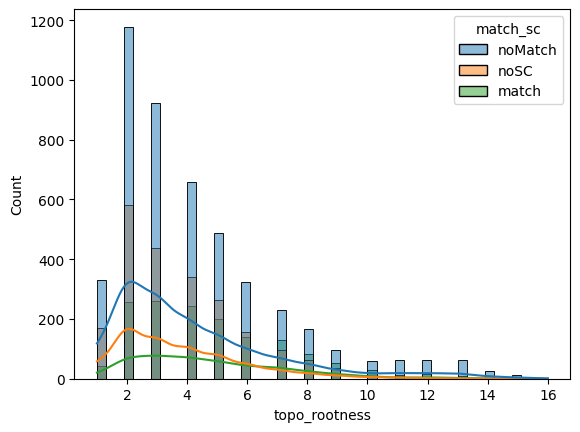

In [8]:
sns.histplot(data = distdf, x = "topo_rootness", hue = "match_sc", bins = 50, kde = True)

In [9]:
for f in ["topo_rootness", "topo_leafness"]:
    for match_type in distdf.match_sc.unique():
        savedf = distdf[distdf["match_sc"] == match_type].groupby(f)["seqid"].count().reset_index()
        savedf.columns = [f, "count"]
        savedf.to_excel(os.path.join(path_to_04_output, "inputHistogram", f"inputHistogram_{f}_{match_type}.xlsx"), index = False)

In [12]:
distdf

,seqid,MID,mouseid,cloneID,CDR3nt,CDR3aa,rootness,topo_rootness,dist_to_deepest,topo_dist_to_deepest,...,leafness,num_node,num_leaves,sample_type,mix_node,V_gene,J_gene,CDR3_len,min_dist_to_sc,match_sc
0,seq1,MID2_MID3,m1,m1_IGHV1-64-01_IGHJ2-01_36_3,TGTGCAAGATGGGAACTATGGACTCTTGACTACTGG,CARWELWTLDYW,37.0,1.0,7.0,1.0,...,7.0,4,2,m1 SI mid_m1 SI prox,yes,IGHV1-64,IGHJ2,36,0.416667,noMatch
1,seq2,MID4,m1,m1_IGHV1-64-01_IGHJ2-01_36_3,TGTGCAAGATGGGAACTATGGGCTCTTGACTACTGG,CARWELWALDYW,38.0,2.0,8.0,1.0,...,0.0,4,2,m1 colon,no,IGHV1-64,IGHJ2,36,0.333333,noMatch
2,seq3,MID4,m1,m1_IGHV1-64-01_IGHJ2-01_36_3,TGTGTAAGATGGGAACTATGGGCTCTTGACTACTGG,CVRWELWALDYW,44.0,2.0,0.0,0.0,...,0.0,4,2,m1 colon,no,IGHV1-64,IGHJ2,36,0.416667,noMatch
3,seq1,MID2_MID4,m1,m1_IGHV1-84-01_IGHJ3-01_42_1,TGTGCAAGGGGGCTAACTGGGACGTCCTGGTTTGCTTACTGG,CARGLTGTSWFAYW,30.0,2.0,59.0,1.0,...,59.0,9,5,m1 SI mid_m1 colon,yes,IGHV1-84,IGHJ3,42,noSC,noSC
4,seq2,MID4,m1,m1_IGHV1-84-01_IGHJ3-01_42_1,TGTGCAAGGGGGCTAACTGGGACGTCCTGGTTTGCTTACTGG,CARGLTGTSWFAYW,89.0,3.0,0.0,0.0,...,0.0,9,5,m1 colon,no,IGHV1-84,IGHJ3,42,noSC,noSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,seq2,MID13,m3,m3_IGHV1-72-01_IGHJ4-01_36_1,TGTGCCGTATGATTAATACGGTCTAAGGACCACTGG,CAV*LIRSKDHW,78.0,3.0,0.0,0.0,...,0.0,11,5,m3 colon,no,IGHV1-72,IGHJ4,36,0.666667,noMatch
8320,seq3,MID13_MID13,m3,m3_IGHV1-72-01_IGHJ4-01_36_1,TGTGCCGTATGATTAATACGGTCTAAGGACTACTGG,CAV*LIRSKDYW,69.0,4.0,31.0,4.0,...,7.0,11,5,m3 colon,no,IGHV1-72,IGHJ4,36,0.583333,noMatch
8321,seq4,MID13,m3,m3_IGHV1-72-01_IGHJ4-01_36_1,TGTGCCGTATGATTAATACGGTCTAAGGACTACTGG,CAV*LIRSKDYW,76.0,5.0,38.0,5.0,...,0.0,11,5,m3 colon,no,IGHV1-72,IGHJ4,36,0.583333,noMatch
8322,seq5,MID9,m3,m3_IGHV1-72-01_IGHJ4-01_36_1,TGTGCCGTTTGATTAATACGGTCTAAGGACTACTGG,CAV*LIRSKDYW,68.0,3.0,30.0,3.0,...,0.0,11,5,m3 SI dist,no,IGHV1-72,IGHJ4,36,0.583333,noMatch
